## 5e. Test the hypothesis that animals are closer to the well for the theta sequences extending farther away from the animal.

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import spyglass as nd
import pandas as pd
import numpy as np
import xarray as xr
from scipy import stats
from scipy import linalg
import os
import pickle
import matplotlib.pyplot as plt
from ripple_detection.core import segment_boolean_series

from spyglass.common import (Session, IntervalList,LabMember, LabTeam, Raw, Session, Nwbfile,
                            Electrode,LFPBand,interval_list_intersect)
from spyglass.common import TaskEpoch
from spyglass.spikesorting.v0 import (SortGroup, 
                                    SpikeSortingRecording,SpikeSortingRecordingSelection)
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common.common_position import IntervalPositionInfo, RawPosition, IntervalLinearizedPosition, TrackGraph

[2025-03-13 21:51:31,284][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2025-03-13 21:51:31,322][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [4]:
from spyglass.shijiegu.pairwiseDecode import merge_overlapping_ranges,removeEmptyDecode
from spyglass.shijiegu.ripple_add_replay import remove_adjacent
from spyglass.shijiegu.pairwiseDecode import replay_transitions,categorized_replay_transitions,behavior_transitions,behavior_transitions_count,findXCorrAllDays
from spyglass.shijiegu.decodeHelpers import runSessionNames

In [5]:
from spyglass.shijiegu.Analysis_SGU import TrialChoice,EpochPos,MUA,get_linearization_map,TrialChoiceChangeOfMind
from spyglass.shijiegu.decodeHelpers import runSessionNames
from spyglass.shijiegu.ripple_add_replay import plot_decode_spiking
from spyglass.shijiegu.changeOfMind import (find_turnaround_time, findProportion,
            find_trials, load_epoch_data_wrapper, find_direction, find_trials_animal,
            find_statescrripts)
from spyglass.shijiegu.changeOfMind_triggered import (find_triggered_animal,find_triggered_transition_animal,
    find_triggered_log_session, find_triggered_log_animal,fitLM,labels,seq1,seq2,rev1,rev2,rev3)

[21:51:36][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[21:51:36][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[21:51:36][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[21:51:36][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.


In [6]:
import statsmodels.api as sm
from spyglass.shijiegu.changeOfMind_triggered import (find_triggered_animal,
    plot_physical_vs_mental_position, parse_to_transitions, 
    find_large_position_minus_decode_trials, normalize_to_1, matrix_correlation,
    find_behavior_sum, find_transitions_sum, find_transitions, correlate_transition_deltabehavior,trials_date_session_to_dict
)
from spyglass.shijiegu.pairwiseDecode import behavior_transitions_count

In [12]:
from spyglass.shijiegu.changeOfMind_proportion import find_proportion_by_theta

In [7]:
animal = 'eliot'
dates_to_plot = ['20221018','20221019','20221020','20221021','20221022','20221023','20221024','20221025','20221026']

encoding_set = '2Dheadspeed_above_4_andlowmua'
classifier_param_name = 'default_decoding_gpu_4armMaze'
datafolder = f'/cumulus/shijie/behavior_pilot/Batch1/{animal}'

In [156]:
animal = 'lewis'

dates_to_plot = ['20240105','20240106','20240107','20240108','20240109',
                 '20240110']#'20240114']#'20240115','20240116','20240117','20240118','20240119','20240120']

#dates_to_plot = ['20240115','20240116','20240117','20240118','20240119','20240120']

In [186]:
animal = 'lewis'
dates_to_plot = ['20240115','20240116','20240117','20240118','20240119','20240120']

In [200]:
dates_to_plot

['20221018',
 '20221019',
 '20221020',
 '20221021',
 '20221022',
 '20221023',
 '20221024',
 '20221025',
 '20221026']

In [15]:
replay_trials = {}
replay_trials_non = {}

replay_trials[animal] = {}
replay_trials_non[animal] = {}

for d in dates_to_plot:
    (triggered_positions, triggered_positions_abs) = ({}, {})
    (triggered_decodes, triggered_decodes_baseoff, triggered_decodes_abs) = ({}, {}, {})
    triggered_trial_info = {}

    (triggered_positions[animal], triggered_positions_abs[animal],
     triggered_decodes[animal], triggered_decodes_baseoff[animal], triggered_decodes_abs[animal],
     triggered_trial_info[animal]) = find_triggered_animal(animal,[d],
                                                           delta_t_minus = 0,delta_t_plus = 2,
                                                           max_flag = 0, segment_only = True)

    (triggered_positions_nb, triggered_positions_abs_nb) = ({}, {})
    (triggered_decodes_nb, triggered_decodes_baseoff_nb, triggered_decodes_abs_nb) = ({}, {}, {})
    
    (triggered_positions_nb[animal], triggered_positions_abs_nb[animal],
     triggered_decodes_nb[animal], triggered_decodes_baseoff_nb[animal], triggered_decodes_abs_nb[animal],
     _) = find_triggered_animal(animal,[d], nearby = 1,
                                delta_t_minus = 2,delta_t_plus = 0.5,
                                max_flag = 0, segment_only = True)


    
    replay_trials[animal][d], inds, _, replay_trials_non[animal][d], inds_non, _ = find_large_position_minus_decode_trials(
        # with theta                # without theta
                animal, triggered_trial_info, 
                triggered_positions_abs, triggered_decodes_baseoff, triggered_positions_abs_nb, triggered_decodes_baseoff_nb)
    


[22:20:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[22:20:28][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[22:20:28][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times
currently investigating:
05_Seq2Session3
pos 4 valid times


[22:20:29][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
07_Seq2Session4
pos 6 valid times


[22:20:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
09_Seq2Session5
pos 8 valid times


[22:20:31][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
11_Seq2Session6
pos 10 valid times


[22:20:31][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[22:20:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[22:20:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times
currently investigating:
05_Seq2Session3
pos 4 valid times


[22:20:33][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
07_Seq2Session4
pos 6 valid times


[22:20:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
09_Seq2Session5
pos 8 valid times


[22:20:34][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
11_Seq2Session6
pos 10 valid times


[22:21:18][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[22:21:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[22:21:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[22:21:23][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times
some missing position data
some missing position data


[22:21:25][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[22:21:27][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[22:21:28][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[22:21:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[22:21:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[22:21:33][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[22:22:11][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[22:22:12][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[22:22:13][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[22:22:14][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[22:22:15][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times
some missing position data
some missing position data


[22:22:17][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
12_Seq2Session6
pos 11 valid times


[22:22:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[22:22:20][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[22:22:22][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[22:22:23][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[22:22:24][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[22:22:26][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
12_Seq2Session6
pos 11 valid times


[22:23:04][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[22:23:06][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[22:23:09][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times
some missing position data


[22:23:10][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[22:23:11][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[22:23:12][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[22:23:13][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[22:23:14][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[22:23:36][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[22:23:37][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[22:23:37][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[22:23:38][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[22:23:38][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[22:23:39][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[22:23:40][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[22:23:40][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[22:23:41][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[22:23:42][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[22:24:19][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[22:24:20][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[22:24:20][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[22:24:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[22:24:21][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


some missing position data
currently investigating:
02_Seq2Session1
pos 1 valid times


[22:24:22][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[22:24:22][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[22:24:23][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[22:24:49][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session2
pos 1 valid times


[22:24:50][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session3
pos 3 valid times


[22:24:50][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session4
pos 5 valid times


[22:24:51][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session5
pos 7 valid times


[22:24:52][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session6
pos 9 valid times


[22:24:52][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session2
pos 1 valid times


[22:24:53][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session3
pos 3 valid times


[22:24:53][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session4
pos 5 valid times


[22:24:54][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session5
pos 7 valid times


[22:24:54][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session6
pos 9 valid times


[22:25:29][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[22:25:29][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[22:25:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[22:25:30][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[22:25:31][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[22:25:31][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[22:25:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[22:25:32][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[22:25:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[22:26:00][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[22:26:00][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[22:26:01][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
08_Seq2Session4
pos 7 valid times


[22:26:01][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[22:26:01][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
12_Seq2Session6
pos 11 valid times


[22:26:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
02_Seq2Session1
pos 1 valid times


[22:26:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
04_Seq2Session2
pos 3 valid times


[22:26:02][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
06_Seq2Session3
pos 5 valid times


[22:26:03][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


some missing position data
currently investigating:
08_Seq2Session4
pos 7 valid times


[22:26:03][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
10_Seq2Session5
pos 9 valid times


[22:26:04][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


currently investigating:
12_Seq2Session6
pos 11 valid times


In [16]:
from scipy.stats import permutation_test
from scipy.stats import mode
# because our statistic is vectorized, we pass `vectorized=True`
# `n_resamples=np.inf` indicates that an exact test is to be performed

def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

### First, paired comparisons.
Limited data points

In [33]:
prop_theta_transition_day = {}
prop_nontheta_transition_day = {}

for day in dates_to_plot:
    nwb_file_name = animal.lower() + day + '.nwb'
    nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)
    session_interval, position_interval = runSessionNames(nwb_copy_file_name)

    prop_theta_transition_session = []
    prop_nontheta_transition_session = []
    for ind in range(len(session_interval)):
        session_name = session_interval[ind]
        position_name = position_interval[ind]
        prop_theta_transition_session_, prop_nontheta_transition_session_ = find_proportion_by_theta(
            nwb_copy_file_name, session_name, replay_trials, replay_trials_non) #replay_trials)
        
        prop_theta_transition_session.append(prop_theta_transition_session_)
        prop_nontheta_transition_session.append(prop_nontheta_transition_session_)

    prop_theta_transition_day[day] = prop_theta_transition_session
    prop_nontheta_transition_day[day] = prop_nontheta_transition_session

eliot20221018_.nwb 02_Seq2Session1
eliot20221018_.nwb 04_Seq2Session2
eliot20221018_.nwb 05_Seq2Session3
eliot20221018_.nwb 07_Seq2Session4
eliot20221018_.nwb 09_Seq2Session5
eliot20221018_.nwb 11_Seq2Session6
eliot20221019_.nwb 02_Seq2Session1
eliot20221019_.nwb 04_Seq2Session2
eliot20221019_.nwb 06_Seq2Session3
eliot20221019_.nwb 08_Seq2Session4
eliot20221019_.nwb 10_Seq2Session5
eliot20221020_.nwb 02_Seq2Session1
eliot20221020_.nwb 04_Seq2Session2
eliot20221020_.nwb 06_Seq2Session3
eliot20221020_.nwb 08_Seq2Session4
eliot20221020_.nwb 10_Seq2Session5
eliot20221020_.nwb 12_Seq2Session6
eliot20221021_.nwb 02_Seq2Session1
eliot20221021_.nwb 04_Seq2Session2
eliot20221021_.nwb 06_Seq2Session3
eliot20221021_.nwb 08_Seq2Session4
eliot20221022_.nwb 02_Seq2Session1
eliot20221022_.nwb 04_Seq2Session2
eliot20221022_.nwb 06_Seq2Session3
eliot20221022_.nwb 08_Seq2Session4
eliot20221022_.nwb 10_Seq2Session5
eliot20221023_.nwb 02_Seq2Session1
eliot20221023_.nwb 04_Seq2Session2
eliot20221023_.nwb 0

In [32]:
%debug

> /home/shijiegu/Documents/spyglass/src/spyglass/shijiegu/changeOfMind_proportion.py(33)session_long_theta_trials()
     31         if tup[0] == nwb_copy_file_name and tup[1] == session_name:
     32             max_prop = log_df.loc[tup[2]].CoMMaxProportion
---> 33             if len(max_prop) > 0:
     34                 CoMMaxProportion.append(max_prop[0])
     35     return CoMMaxProportion



ipdb>  log_df.loc[tup[2]].CoMMaxProportion


0.3013265340061907


ipdb>  exit


In [34]:
prop_nontheta_transition_day

{'20221018': [[0.18792827162886597],
  [0.08643146458302366],
  [0.4395622651546554, 0.12710137007626063],
  [0.09575178578399762,
   1.0,
   0.15999234395214032,
   0.1945488714699208,
   0.1144333373678273,
   0.05612963266129955],
  [0.07930073511583964,
   0.09637547370568363,
   0.10350989499963975,
   0.27681184370711676],
  [0.15360879961135182]],
 '20221019': [[0.11103994848277329,
   0.16243489461790084,
   0.18551429779227951,
   0.0669532378312163],
  [0.1669762693015138,
   0.12074336811841808,
   0.23217930617485202,
   0.1932416413090012,
   0.3709745594588305,
   0.15944770945616307,
   0.18671737772745625,
   0.3127481160516132,
   0.3127481160516132,
   0.17443339644688707,
   0.07633855732066133,
   0.39752808031077697,
   0.5558828557585804],
  [0.05523028458147777,
   0.5194195510990419,
   0.15833262617834737,
   0.2673893477677696,
   0.2673893477677696,
   0.2569235723486545,
   0.2569235723486545,
   0.2669968411854042,
   0.3516191095554238,
   0.26937256146512

In [30]:
prop_theta_transition_day

{'20221018': [[0.3013265340061907], [], [], [], [], []],
 '20221019': [[0.37314944425129853,
   0.24760890879908845,
   0.4253004970612373,
   0.4253004970612373],
  [0.3618721684075164,
   0.3732600273460671,
   0.5939484810615916,
   0.5939484810615916,
   0.5558828557585804,
   0.5558828557585804],
  [0.37588182354908256,
   0.5194195510990419,
   0.5194195510990419,
   0.5271916718859821],
  [0.4644309179672476,
   0.49681855601671177,
   0.28585228821580977,
   0.42208488187755167],
  [0.5866126696034264]],
 '20221020': [[0.45525745948380253],
  [],
  [0.41999936919274866, 0.32594492703888395],
  [0.20747714931732, 0.09202890114677106],
  [],
  [0.3003293151910658,
   0.4260299154764835,
   0.30445137572789444,
   0.2181309340756276]],
 '20221021': [[0.06349207832134728, 0.320446512620185],
  [0.5083020539013275,
   0.5083020539013275,
   0.2647070309288513,
   0.16208023323955556,
   0.16208023323955556,
   0.4012083754990561],
  [0.29925501941315, 0.2016507364609207, 0.184535944

In [27]:
log_df.loc[:50]

,timestamp_H,Home,timestamp_O,OuterWellIndex,rewardNum,change_of_mind,CoMMaxProportion,CoM_t,CoM_arm,current,future_H,future_O,past,past_reward
1,1.666198e+09,1.0,1.666198e+09,4.0,1.0,False,[],[],[],4.0,4.0,2.0,NaN,NaN
2,1.666198e+09,1.0,1.666198e+09,2.0,1.0,False,[],[],[],2.0,2.0,3.0,4.0,NaN
3,1.666198e+09,1.0,1.666198e+09,3.0,2.0,False,[],[],[],3.0,3.0,1.0,2.0,NaN
4,1.666198e+09,1.0,1.666198e+09,1.0,1.0,False,[],[],[],1.0,1.0,4.0,3.0,3.0
5,NaN,NaN,1.666198e+09,4.0,0.0,False,[],[],[],4.0,4.0,2.0,1.0,3.0
6,1.666198e+09,1.0,1.666198e+09,2.0,1.0,False,[],[],[],2.0,2.0,3.0,4.0,3.0
7,1.666198e+09,1.0,1.666198e+09,3.0,1.0,True,0.11104,[[1666198066.3680778]],"[[1, 3, -9223372036854775808]]",3.0,3.0,1.0,2.0,3.0
8,1.666198e+09,1.0,1.666198e+09,1.0,1.0,False,[],[],[],1.0,1.0,3.0,3.0,3.0
9,1.666198e+09,1.0,1.666198e+09,3.0,1.0,False,[],[],[],3.0,3.0,2.0,1.0,3.0
10,1.666198e+09,1.0,1.666198e+09,2.0,1.0,True,0.373149,[[1666198134.6120543]],"[[1, 2, -9223372036854775808]]",2.0,2.0,4.0,3.0,3.0


In [36]:
prop_theta_transition_day['20221018']

[[0.3013265340061907], [], [], [], [], []]

[Text(0, 0, 'theta'), Text(1, 0, 'nontheta')]

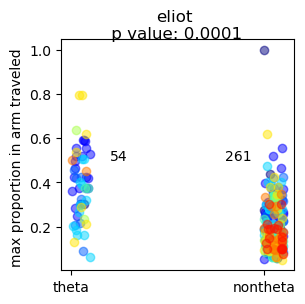

In [43]:
dates_to_plot = list(replay_trials[animal].keys())
transitions = [(0,1),(0,2),(0,3),
               (1,0),(1,2),(1,3),
               (2,0),(2,1),(2,3),
               (3,0),(3,1),(3,2)]

# plotting stuff
cmap = plt.cm.jet
norm = plt.Normalize(vmin=0, vmax=len(dates_to_plot))

fig,axes = plt.subplots(1,1,figsize = (3,3),sharex = True, sharey = True)

sample_theta = []
sample_nontheta = []

d_ind = 0
for d in prop_theta_transition_day.keys():
    prop_theta_day = prop_theta_transition_day[d]
    prop_nontheta_day = prop_nontheta_transition_day[d]
    for prop_theta_session in prop_theta_day:

        axes.scatter(np.zeros_like(np.array(prop_theta_session)) + np.random.uniform(0,0.1,len(prop_theta_session)),
                     np.array(prop_theta_session),
                     color = cmap(norm(d_ind)), alpha = 0.5)
        for prop in prop_theta_session:
            sample_theta.append(prop)

    for prop_nontheta_session in prop_nontheta_day:

        axes.scatter(np.zeros_like(np.array(prop_nontheta_session)) + 1 + np.random.uniform(0,0.1,len(prop_nontheta_session)),
                     np.array(prop_nontheta_session),
                     color = cmap(norm(d_ind)), alpha = 0.5)
        for prop in prop_nontheta_session:
            sample_nontheta.append(prop)

            
    d_ind += 1

#statistic, pvalue = ranksums(sample_theta, sample_nontheta, "greater")
res = permutation_test((sample_theta, sample_nontheta), statistic, vectorized=True,
                       n_resamples=10000, alternative='greater')

axes.text(0.2, 0.5, len(sample_theta))
axes.text(0.8, 0.5, len(sample_nontheta))

axes.set_ylabel("max proportion in arm traveled ")
plt.suptitle(animal + '\n p value: '+str(np.round(res.pvalue,4)))    

axes.set_xticks([0,1])

axes.set_xticklabels(["theta","nontheta"])

In [44]:
54/261

0.20689655172413793

In [220]:
print(f"len(sample_theta): {len(sample_theta)},  len(sample_nontheta):{len(sample_nontheta)}")

len(sample_theta): 35,  len(sample_nontheta):13


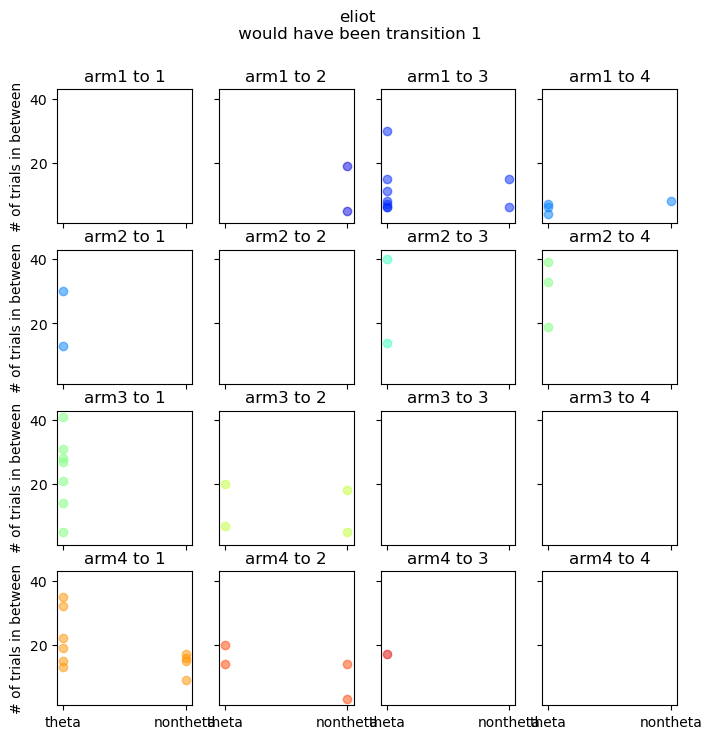

In [221]:
dates_to_plot = list(replay_trials[animal].keys())
transitions = [(0,1),(0,2),(0,3),
               (1,0),(1,2),(1,3),
               (2,0),(2,1),(2,3),
               (3,0),(3,1),(3,2)]

# plotting stuff
cmap = plt.cm.jet
norm = plt.Normalize(vmin=0, vmax=len(transitions))

fig,axes = plt.subplots(4,4,figsize = (8,8),sharex = True, sharey = True)

d_ind = 0
for d in diff_theta_transition_day.keys():
    diff_theta_day = diff_theta_transition_day[d]
    diff_nontheta_day = diff_nontheta_transition_day[d]
    
    for diff_theta_ind in range(len(diff_theta_day)):
        diff_theta = diff_theta_day[diff_theta_ind]
        
        for transition in diff_theta.keys():
            transition_ind = (transition[0] - 1) * 3 + (transition[1] - 1)
            axe_i, axe_j = transition #int(np.floor(t_ind/3)), int(t_ind % 3)
            axes[axe_i - 1, axe_j - 1].scatter(np.zeros_like(diff_theta[transition]), diff_theta[transition],
                                   color = cmap(norm(transition_ind)), alpha = 0.5)

    for diff_nontheta_ind in range(len(diff_nontheta_day)):
        diff_nontheta = diff_nontheta_day[diff_nontheta_ind]
        
        for transition in diff_nontheta.keys():
            transition_ind = (transition[0] - 1) * 3 + (transition[1] - 1)
            axe_i, axe_j = transition #int(np.floor(t_ind/3)), int(t_ind % 3)
            axes[axe_i - 1, axe_j - 1].scatter(np.zeros_like(diff_nontheta[transition]) + 1, diff_nontheta[transition],
                                   color = cmap(norm(transition_ind)), alpha = 0.5)
    d_ind += 1

plt.suptitle(animal + '\n would have been transition 1')    

for axe_i in range(4):
    for axe_j in range(4):
        axes[axe_i, axe_j].set_xticks([0,1])
        if axe_j == 0:
            axes[axe_i, axe_j].set_ylabel("# of trials in between")
        if axe_i == 3:
            axes[axe_i, axe_j].set_xticklabels(["theta","nontheta"])
        axes[axe_i, axe_j].set_title(f"arm{axe_i+1} to {axe_j+1}")

In [128]:
replay_trials[animal]['20221019']

[('eliot20221019_.nwb', '02_Seq2Session1', 10, 1),
 ('eliot20221019_.nwb', '02_Seq2Session1', 52, 3),
 ('eliot20221019_.nwb', '02_Seq2Session1', 57, 1),
 ('eliot20221019_.nwb', '02_Seq2Session1', 57, 1),
 ('eliot20221019_.nwb', '04_Seq2Session2', 16, 1),
 ('eliot20221019_.nwb', '04_Seq2Session2', 45, 1),
 ('eliot20221019_.nwb', '04_Seq2Session2', 76, 4),
 ('eliot20221019_.nwb', '04_Seq2Session2', 76, 2),
 ('eliot20221019_.nwb', '04_Seq2Session2', 81, 1),
 ('eliot20221019_.nwb', '04_Seq2Session2', 81, 3),
 ('eliot20221019_.nwb', '06_Seq2Session3', 8, 3),
 ('eliot20221019_.nwb', '06_Seq2Session3', 15, 3),
 ('eliot20221019_.nwb', '08_Seq2Session4', 25, 1),
 ('eliot20221019_.nwb', '08_Seq2Session4', 33, 3),
 ('eliot20221019_.nwb', '08_Seq2Session4', 34, 1),
 ('eliot20221019_.nwb', '08_Seq2Session4', 37, 1),
 ('eliot20221019_.nwb', '10_Seq2Session5', 26, 2)]

In [60]:
(nwb_copy_file_name, session_name, trial, _ ) = replay_trials[animal]['20221021'][1]

In [159]:
d = '20221019'

nwb_copy_file_name = 'eliot'+ d + '_.nwb'
print(nwb_copy_file_name)
session_name = '02_Seq2Session1'



eliot20221019_.nwb
trials_all_transition [8, 24, 28, 32, 47, 55, 59, 65, 75, 79]
trials_theta_transition [52]
trials_all_transition [3, 7, 12, 16, 33, 38, 44, 72, 80]
trials_theta_transition [10 57]


In [161]:
diff_theta_all

[8, 5, 28]

In [162]:
diff_nontheta_all

[15, 4, 6]

In [141]:
transition

array([3, 1])

In [ ]:
# for a CoM trial, find would have been transition

# find the time before it repeats



In [234]:
animal = 'Lewis'

dates_to_plot = ['20240105','20240106','20240107','20240108','20240109',
                 '20240110']#'20240114']#'20240115','20240116','20240117','20240118','20240119','20240120']

dates_to_plot = ['20240115','20240116','20240117','20240118','20240119','20240120']

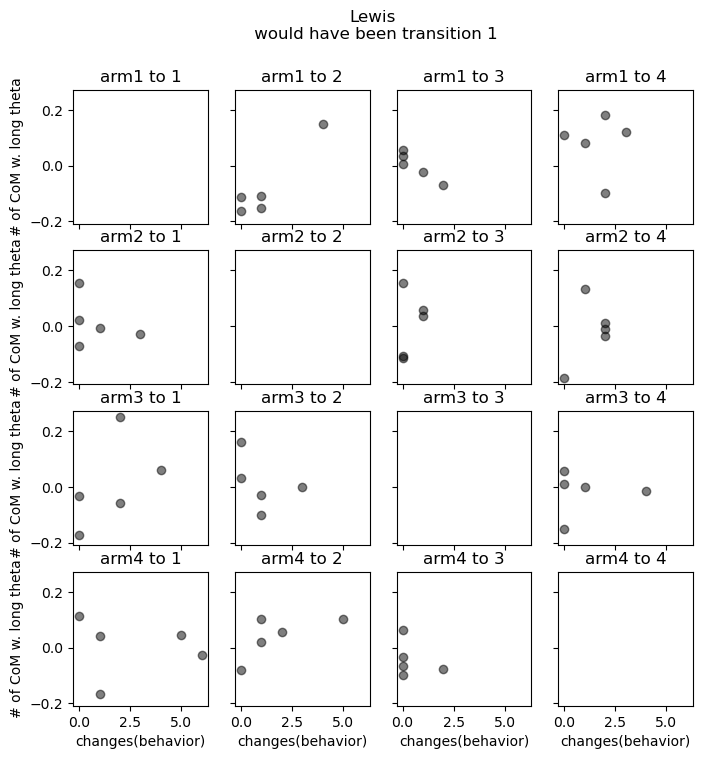

In [244]:
dates_to_plot = list(replay_trials[animal].keys())
transitions = [(0,1),(0,2),(0,3),
               (1,0),(1,2),(1,3),
               (2,0),(2,1),(2,3),
               (3,0),(3,1),(3,2)]

# for aggregate plot
T_wouldhave_count1 = []
T_wouldhave_count2 = []
behavior_count = []

# plotting stuff
cmap = plt.cm.jet
norm = plt.Normalize(vmin=0, vmax=len(dates_to_plot))

fig,axes = plt.subplots(4,4,figsize = (8,8),sharex = True, sharey = True)

for d_ind in range(len(dates_to_plot)-1):
    d = dates_to_plot[d_ind]
    d2 = dates_to_plot[d_ind + 1]
    if len(replay_trials[animal][d]) == 0:
        continue
    T, T_wouldhave, T_wouldhave2 = find_transitions(replay_trials[animal][d])
    delta_behavior = find_behavior_sum(animal,None,[d,d2])

    # for lumping across transitions
    behavior_count.append(delta_behavior.ravel())
    T_wouldhave_count1.append(T_wouldhave[list(T_wouldhave.keys())[0]].ravel())
    T_wouldhave_count2.append(T_wouldhave2[list(T_wouldhave2.keys())[0]].ravel())

    # for individual transitions
    for t_ind in range(len(transitions)):
        (i,j) = transitions[t_ind]
        axe_i, axe_j = (i,j)#int(np.floor(t_ind/3)), int(t_ind % 3)
        axes[axe_i, axe_j].scatter(T_wouldhave[list(T_wouldhave.keys())[0]][i,j], delta_behavior[i,j],
                                   color = 'k', alpha = 0.5)
                                  #color = cmap(norm(d_ind)))
plt.suptitle(animal + '\n would have been transition 1')    

for axe_i in range(4):
    for axe_j in range(4):
        if axe_j == 0:
            axes[axe_i, axe_j].set_ylabel("# of CoM w. long theta")
        if axe_i == 3:
            axes[axe_i, axe_j].set_xlabel("changes(behavior)")
        axes[axe_i, axe_j].set_title(f"arm{axe_i+1} to {axe_j+1}")

Text(0.5, 1.0, 'Lewis\n would have been transition 1')

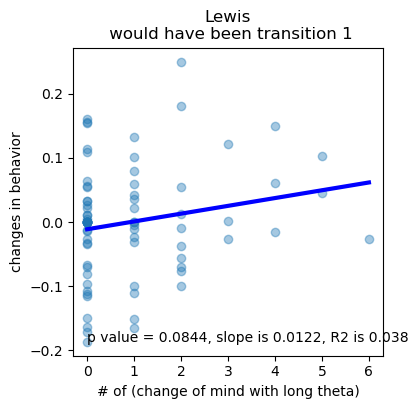

In [240]:
fig,axes = plt.subplots(1,1,figsize = (4,4),sharex = True, sharey = True)
x = np.concatenate(T_wouldhave_count1)
y = np.concatenate(behavior_count)
results, pvalue = fitLM(x,y)
    
axes.scatter(x, y, alpha = 0.4)
x_plot=np.linspace(np.min(x),np.max(x),10).reshape(-1,1)
y_plot=results.predict(sm.add_constant(x_plot))
pvalue_beta = results.pvalues[1]
    
axes.plot(x_plot,y_plot,color='blue',linewidth=3,label = str(pvalue))
axes.text(np.min(x),np.min(y),
          f'p value = {np.round(pvalue_beta,4)}, slope is {np.round(results.params[1],4)}, R2 is {np.around(results.rsquared,3)}')
axes.set_xlabel("# of (change of mind with long theta)")
axes.set_ylabel("changes in behavior")

#jitter = np.random.uniform(high = 0.2, size = len(np.concatenate(T_wouldhave_count1)))
#axes.scatter(np.concatenate(T_wouldhave_count1),np.concatenate(behavior_count) > 0 + jitter, alpha = 0.4)

plt.title(animal + '\n would have been transition 1')

Text(0.5, 1.0, 'Lewis\n would have been transition 1')

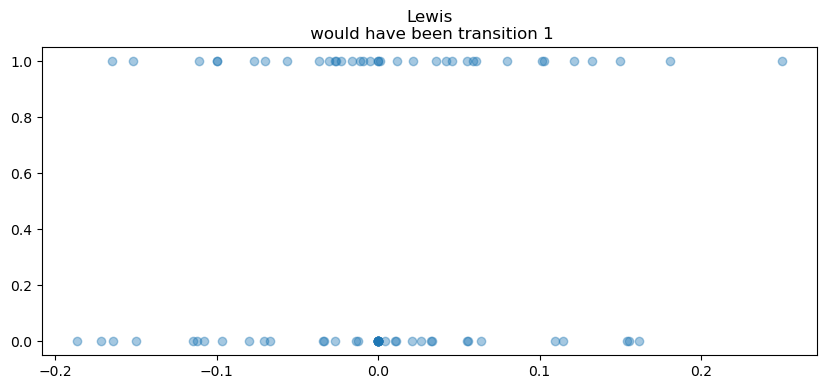

In [238]:
fig,axes = plt.subplots(1,1,figsize = (10,4),sharex = True, sharey = True)
x = np.concatenate(T_wouldhave_count1)
y = np.concatenate(behavior_count)
#results, pvalue = fitLM(x,y)
    
axes.scatter(y, x > 0, alpha = 0.4)
#x_plot=np.linspace(np.min(x),np.max(x),10).reshape(-1,1)
#y_plot=results.predict(sm.add_constant(x_plot))
#pvalue_beta = results.pvalues[1]
    
#axes.plot(x_plot,y_plot,color='blue',linewidth=3,label = str(pvalue))
#axes.text(np.min(x),np.min(y),
#          f'p value = {np.round(pvalue_beta,4)}, slope is {np.round(results.params[1],4)}, R2 is {np.around(results.rsquared,3)}')

#jitter = np.random.uniform(high = 0.2, size = len(np.concatenate(T_wouldhave_count1)))
#axes.scatter(np.concatenate(T_wouldhave_count1),np.concatenate(behavior_count) > 0 + jitter, alpha = 0.4)

plt.title(animal + '\n would have been transition 1')

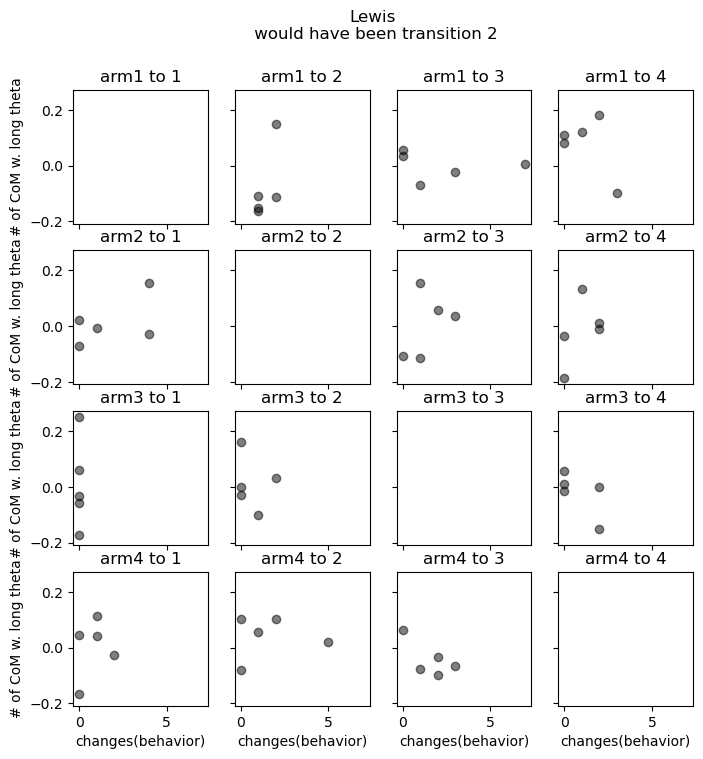

In [245]:
dates_to_plot = list(replay_trials[animal].keys())
transitions = [(0,1),(0,2),(0,3),
               (1,0),(1,2),(1,3),
               (2,0),(2,1),(2,3),
               (3,0),(3,1),(3,2)]

# plotting stuff
cmap = plt.cm.jet
norm = plt.Normalize(vmin=0, vmax=len(dates_to_plot))

fig,axes = plt.subplots(4,4,figsize = (8,8),sharex = True, sharey = True)

for d_ind in range(len(dates_to_plot)-1):
    d = dates_to_plot[d_ind]
    d2 = dates_to_plot[d_ind + 1]
    if len(replay_trials[animal][d]) == 0:
        continue
    T, T_wouldhave, T_wouldhave2 = find_transitions(replay_trials[animal][d])
    delta_behavior = find_behavior_sum(animal,None,[d,d2])
    for t_ind in range(len(transitions)):
        (i,j) = transitions[t_ind]
        axe_i, axe_j = (i,j)#int(np.floor(t_ind/3)), int(t_ind % 3)
        axes[axe_i, axe_j].scatter(T_wouldhave2[list(T_wouldhave2.keys())[0]][i,j], delta_behavior[i,j],
                                   color = 'k', alpha = 0.5)
        
                                  #color = cmap(norm(d_ind)))
plt.suptitle(animal + '\n would have been transition 2')
for axe_i in range(4):
    for axe_j in range(4):
        if axe_j == 0:
            axes[axe_i, axe_j].set_ylabel("# of CoM w. long theta")
        if axe_i == 3:
            axes[axe_i, axe_j].set_xlabel("changes(behavior)")
        axes[axe_i, axe_j].set_title(f"arm{axe_i+1} to {axe_j+1}")

Text(0.0, -0.26344086021505375, 'p value = 0.2286, slope is -0.01, R2 is 0.011')

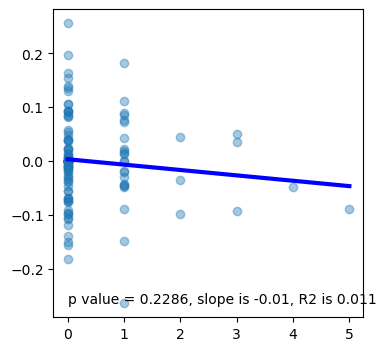

In [233]:
fig,axes = plt.subplots(1,1,figsize = (4,4),sharex = True, sharey = True)
x = np.concatenate(T_wouldhave_count2)
y = np.concatenate(behavior_count)
results, pvalue = fitLM(x,y)
    
axes.scatter(x, y, alpha = 0.4)
x_plot=np.linspace(np.min(x),np.max(x),10).reshape(-1,1)
y_plot=results.predict(sm.add_constant(x_plot))
pvalue_beta = results.pvalues[1]
    
axes.plot(x_plot,y_plot,color='blue',linewidth=3,label = str(pvalue))
axes.text(np.min(x),np.min(y),
          f'p value = {np.round(pvalue_beta,4)}, slope is {np.round(results.params[1],4)}, R2 is {np.around(results.rsquared,3)}')

#jitter = np.random.uniform(high = 0.2, size = len(np.concatenate(T_wouldhave_count1)))
#axes.scatter(np.concatenate(T_wouldhave_count1),np.concatenate(behavior_count) > 0 + jitter, alpha = 0.4)